In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '../completenessContours')
import compute_num_completeness_w_ve_insol as kp

sys.path.insert(0, '..')
import occRateUtils as ut

import rateModels3D as rm3D

In [2]:
stellarType = "FGK"
catalog = "dr25"
hzType = "optimistic"

if stellarType == "hab":
    teffRange = (4800, 6300)
elif stellarType == "hab2":
    teffRange = (3900, 6300)
elif stellarType == "GK":
    teffRange = (3900, 6000)
elif stellarType == "FGK":
    teffRange = (3900, 7300)
else:
    raise ValueError('Bad catalog name');
    
cs = rm3D.compSpace(periodName = "Instellation", 
               periodUnits = "$I_\oplus$",
               periodRange = (0.2, 2.2), 
               nPeriod = 61, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.5, 2.5), 
               nRp = 61,
               tempName = "$T_\mathrm{eff}$", 
               tempUnits = "$R_\oplus$",
               tempRange = teffRange, 
               nTemp = 10)

# model 1: triplePowerLawTeffAvg
# model 2: triplePowerLaw
# model 3: dualPowerLawFixedTeffAvg
# model 4: dualPowerLaw
# model 5: constantFixedTeffAvg
model = rm3D.triplePowerLawTeffAvg(cs)

# completenessExtrapType = "extrap_const"
completenessExtrapType = "extrap_zero"

# make output directory if needed
outDir = "computeOccurrencefixedTeff_" + catalog + "_" + stellarType + "_"  \
        + model.name + "_" + hzType + "_" + completenessExtrapType + "_out"
if not path.exists(outDir):
    os.mkdir(outDir)



In [3]:
pcCatalog = "koiCatalogs/PCs_" + catalog + "_" + stellarType + ".csv"
base_pcs = pd.read_csv(pcCatalog)

m = (cs.periodRange[0] <= base_pcs.insolation) & (base_pcs.insolation <= cs.periodRange[1])
thisRadii = base_pcs.gaia_iso_prad
m &= np.isfinite(thisRadii) & (cs.rpRange[0] <= thisRadii) & (thisRadii <= cs.rpRange[1])
    
pcs = pd.DataFrame(base_pcs[m])
allPcs = pcs


In [4]:
list(base_pcs)

['kepid_x',
 'kepoi_name',
 'koi_tce_plnt_num',
 'koi_pdisposition',
 'koi_score',
 'koi_period',
 'koi_max_mult_ev',
 'koi_prad',
 'koi_prad_err1',
 'koi_prad_err2',
 'koi_ror',
 'koi_ror_err1',
 'koi_ror_err2',
 'KIC',
 'KOI',
 'koi_disposition',
 'gaia_iso_prad',
 'gaia_iso_prad_errp',
 'gaia_iso_prad_errm',
 'gaia_iso_sma',
 'gaia_iso_sma_errp',
 'gaia_iso_sma_errm',
 'gaia_iso_insol',
 'gaia_iso_insol_errp',
 'gaia_iso_insol_errm',
 'ZAMSFlux',
 'Flag',
 'insolation',
 'TCE_ID',
 'radius',
 'radius_err1',
 'radius_err2',
 'teff',
 'teff_err1',
 'teff_err2',
 'corrected_prad',
 'corrected_prad_err1',
 'corrected_prad_err2',
 'rowid',
 'kepid_y',
 'fpp_koi_period',
 'fpp_prob',
 'fpEffectiveness',
 'obsFpRate',
 'reliability',
 'fpp_prob_use',
 'totalReliability',
 'Disp']

In [5]:
# compute probability of inclusion from base_kois
from scipy.stats import norm

base_pcs["prob_inclusion_radius"] = 0*base_pcs.gaia_iso_prad
base_pcs["prob_inclusion_insol"] = 0*base_pcs.gaia_iso_prad
base_pcs["prob_inclusion_teff"] = 0*base_pcs.gaia_iso_prad

bothPlus = (cs.rpRange[0] > base_pcs.gaia_iso_prad) & (cs.rpRange[1] > base_pcs.gaia_iso_prad)
bothMinus = (cs.rpRange[0] <= base_pcs.gaia_iso_prad) & (cs.rpRange[1] <= base_pcs.gaia_iso_prad)
plusMinus = (cs.rpRange[0] <= base_pcs.gaia_iso_prad) & (cs.rpRange[1] > base_pcs.gaia_iso_prad)
diffMinus = cs.rpRange[0]-base_pcs.gaia_iso_prad
diffPlus = cs.rpRange[1]-base_pcs.gaia_iso_prad
base_pcs.loc[bothPlus, "prob_inclusion_radius"] = norm.cdf(diffPlus[bothPlus]/base_pcs[bothPlus].gaia_iso_prad_errp) \
                                                - norm.cdf(diffMinus[bothPlus]/base_pcs[bothPlus].gaia_iso_prad_errp)
base_pcs.loc[bothMinus, "prob_inclusion_radius"] = norm.cdf(diffPlus[bothMinus]/base_pcs[bothMinus].gaia_iso_prad_errm) \
                                                - norm.cdf(diffMinus[bothMinus]/base_pcs[bothMinus].gaia_iso_prad_errm)
base_pcs.loc[plusMinus, "prob_inclusion_radius"] = norm.cdf(diffPlus[plusMinus]/base_pcs[plusMinus].gaia_iso_prad_errp) \
                                                - norm.cdf(diffMinus[plusMinus]/base_pcs[plusMinus].gaia_iso_prad_errm)

bothPlus = (cs.periodRange[0] > base_pcs.gaia_iso_insol) & (cs.periodRange[1] > base_pcs.gaia_iso_insol)
bothMinus = (cs.periodRange[0] <= base_pcs.gaia_iso_insol) & (cs.periodRange[1] <= base_pcs.gaia_iso_insol)
plusMinus = (cs.periodRange[0] <= base_pcs.gaia_iso_insol) & (cs.periodRange[1] > base_pcs.gaia_iso_insol)
diffMinus = cs.periodRange[0]-base_pcs.gaia_iso_insol
diffPlus = cs.periodRange[1]-base_pcs.gaia_iso_insol
base_pcs.loc[bothPlus, "prob_inclusion_insol"] = norm.cdf(diffPlus[bothPlus]/base_pcs[bothPlus].gaia_iso_insol_errp) \
                                                - norm.cdf(diffMinus[bothPlus]/base_pcs[bothPlus].gaia_iso_insol_errp)
base_pcs.loc[bothMinus, "prob_inclusion_insol"] = norm.cdf(diffPlus[bothMinus]/base_pcs[bothMinus].gaia_iso_insol_errm) \
                                                - norm.cdf(diffMinus[bothMinus]/base_pcs[bothMinus].gaia_iso_insol_errm)
base_pcs.loc[plusMinus, "prob_inclusion_insol"] = norm.cdf(diffPlus[plusMinus]/base_pcs[plusMinus].gaia_iso_insol_errp) \
                                                - norm.cdf(diffMinus[plusMinus]/base_pcs[plusMinus].gaia_iso_insol_errm)

bothPlus = (cs.tempRange[0] > base_pcs.teff) & (cs.tempRange[1] > base_pcs.teff)
bothMinus = (cs.tempRange[0] <= base_pcs.teff) & (cs.tempRange[1] <= base_pcs.teff)
plusMinus = (cs.tempRange[0] <= base_pcs.teff) & (cs.tempRange[1] > base_pcs.teff)
diffMinus = cs.tempRange[0]-base_pcs.teff
diffPlus = cs.tempRange[1]-base_pcs.teff
base_pcs.loc[bothPlus, "prob_inclusion_teff"] = norm.cdf(diffPlus[bothPlus]/base_pcs[bothPlus].teff_err1) \
                                                - norm.cdf(diffMinus[bothPlus]/base_pcs[bothPlus].teff_err1)
base_pcs.loc[bothMinus, "prob_inclusion_teff"] = norm.cdf(diffPlus[bothMinus]/base_pcs[bothMinus].teff_err2) \
                                                - norm.cdf(diffMinus[bothMinus]/base_pcs[bothMinus].teff_err2)
base_pcs.loc[plusMinus, "prob_inclusion_teff"] = norm.cdf(diffPlus[plusMinus]/base_pcs[plusMinus].teff_err1) \
                                                - norm.cdf(diffMinus[plusMinus]/base_pcs[plusMinus].teff_err2)


/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [6]:
base_pcs[base_pcs.prob_inclusion_radius > 1/400].prob_inclusion_radius

0       0.606639
2       0.014140
3       0.921908
4       0.592810
5       0.110127
          ...   
2510    0.999435
2515    0.009011
2516    1.000000
2518    0.020604
2519    0.859630
Name: prob_inclusion_radius, Length: 2134, dtype: float64

In [7]:
base_pcs[base_pcs.prob_inclusion_insol > 1/400].prob_inclusion_insol

11      0.999983
205     1.000000
268     0.053322
276     0.336130
284     0.436305
          ...   
2418    1.000000
2429    1.000000
2432    0.998982
2490    0.995155
2508    1.000000
Name: prob_inclusion_insol, Length: 151, dtype: float64

In [8]:
base_pcs[base_pcs.prob_inclusion_insol > 1/400].prob_inclusion_teff

11      1.000000
205     1.000000
268     1.000000
276     1.000000
284     0.999994
          ...   
2418    1.000000
2429    1.000000
2432    1.000000
2490    1.000000
2508    1.000000
Name: prob_inclusion_teff, Length: 151, dtype: float64

In [9]:
base_pcs["prob_inclusion" ] = base_pcs.prob_inclusion_radius * base_pcs.prob_inclusion_insol * base_pcs.prob_inclusion_teff
base_pcs[base_pcs.prob_inclusion > 1/4000].prob_inclusion

124     0.000258
182     0.000472
284     0.436240
316     0.019179
434     0.999933
          ...   
2418    0.999999
2429    0.999998
2432    0.998982
2433    0.002493
2508    1.000000
Name: prob_inclusion, Length: 117, dtype: float64

In [10]:
np.sum(base_pcs[base_pcs.prob_inclusion > 1/4000].prob_inclusion)

53.61261474699585

In [11]:
len(pcs)

54

In [12]:
np.sum(base_pcs[base_pcs.prob_inclusion > 1/4000].prob_inclusion*base_pcs[base_pcs.prob_inclusion > 1/4000].gaia_iso_prad)

106.64171702566954

In [13]:
sum(pcs.gaia_iso_prad)

105.00786364855126

In [14]:
prob_pcs = base_pcs[base_pcs.prob_inclusion > 1/4000]


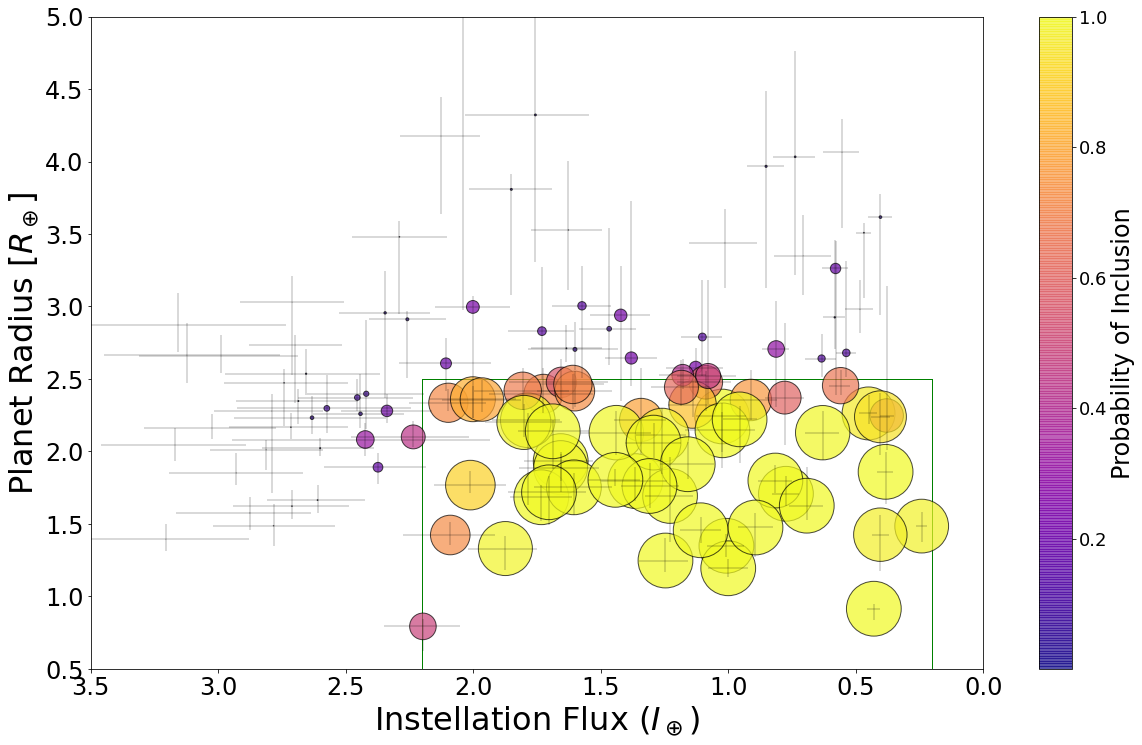

In [19]:
figDir = "summaryFigures"
fig, ax = plt.subplots(figsize=(20,12));

plt.plot([cs.periodRange[0], cs.periodRange[0]], [0.5, 2.5], color='g', linewidth=1)
plt.plot([cs.periodRange[1], cs.periodRange[1]], [0.5, 2.5], color='g', linewidth=1)
plt.plot(cs.periodRange, [0.5, 0.5], color='g', linewidth=1)
plt.plot(cs.periodRange, [2.5, 2.5], color='g', linewidth=1)


scf = plt.scatter(prob_pcs.gaia_iso_insol, prob_pcs.gaia_iso_prad, cmap="plasma", 
               c=prob_pcs.prob_inclusion, edgecolors='k', 
                  s=3000*(prob_pcs.prob_inclusion)**2, alpha = 0.7, zorder=1000)
cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Probability of Inclusion", fontsize = 24);
cbh.ax.tick_params(labelsize=18)

ax.errorbar(prob_pcs.gaia_iso_insol, prob_pcs.gaia_iso_prad, 
            xerr = [prob_pcs.gaia_iso_insol_errm, prob_pcs.gaia_iso_insol_errp],
            yerr = [prob_pcs.gaia_iso_prad_errm, prob_pcs.gaia_iso_prad_errp],
            fmt="none", ecolor="k", alpha = 0.2, marker = None, zorder=2000);

plt.xlim(3.5, 0)
plt.ylim(0.5,5)
plt.tick_params(labelsize = 24)
plt.xlabel('Instellation Flux ($I_\oplus$)', fontsize = 32);
plt.ylabel("Planet Radius [$R_\oplus$]", fontsize = 32);
plt.savefig(figDir + "/probPcInclusion.pdf",bbox_inches='tight')


In [20]:
fs = "{:.2f}"
fs0 = "{:.0f}"
fs4 = "{:.5f}"
for ii, p in prob_pcs.sort_values("prob_inclusion", ascending=False).iterrows():
    if np.isclose(pcs.KOI, p.KOI).any():
        print("{\\bf" + str(p.KOI) + "}" 
              +" & $"+fs.format(p.gaia_iso_prad)+"^{+" 
              + fs.format(p.gaia_iso_prad_errp) 
              + "}_{-" + fs.format(p.gaia_iso_prad_errm)  + "}$"
              +" & "+fs.format(p.koi_period)
              +" & $"+fs.format(p.gaia_iso_insol)+"^{+" 
              + fs.format(p.gaia_iso_insol_errp) 
              + "}_{-" + fs.format(p.gaia_iso_insol_errm)  + "}$"
              +" & $"+fs0.format(p.teff)+"^{+" 
              + fs0.format(p.teff_err1) 
              + "}_{-" + fs0.format(p.teff_err2)  + "}$"
              +" & "+fs.format(p.totalReliability)
              +" & "+fs4.format(p.prob_inclusion)
              + " \\\\")
    else:
        print(str(p.KOI) 
              +" & $"+fs.format(p.gaia_iso_prad)+"^{+" 
              + fs.format(p.gaia_iso_prad_errp) 
              + "}_{-" + fs.format(p.gaia_iso_prad_errm)  + "}$"
              +" & "+fs.format(p.koi_period)
              +" & $"+fs.format(p.gaia_iso_insol)+"^{+" 
              + fs.format(p.gaia_iso_insol_errp) 
              + "}_{-" + fs.format(p.gaia_iso_insol_errm)  + "}$"
              +" & $"+fs0.format(p.teff)+"^{+" 
              + fs0.format(p.teff_err1) 
              + "}_{-" + fs0.format(p.teff_err2)  + "}$"
              +" & "+fs.format(p.totalReliability)
              +" & "+fs4.format(p.prob_inclusion)
              + " \\\\")



{\bf4742.01} & $1.35^{+0.08}_{-0.08}$ & 112.30 & $1.01^{+0.08}_{-0.07}$ & $4602^{+84}_{-76}$ & 0.91 & 1.00000 \\
{\bf8107.01} & $1.19^{+0.06}_{-0.06}$ & 578.89 & $1.00^{+0.08}_{-0.08}$ & $5832^{+102}_{-103}$ & 0.62 & 1.00000 \\
{\bf7016.01} & $1.46^{+0.09}_{-0.08}$ & 384.85 & $1.11^{+0.08}_{-0.08}$ & $5900^{+102}_{-100}$ & 0.68 & 1.00000 \\
{\bf2719.02} & $1.25^{+0.15}_{-0.08}$ & 106.26 & $1.25^{+0.10}_{-0.09}$ & $4601^{+81}_{-76}$ & 0.96 & 1.00000 \\
{\bf701.03} & $1.80^{+0.07}_{-0.04}$ & 122.39 & $1.44^{+0.11}_{-0.10}$ & $4966^{+82}_{-82}$ & 1.00 & 1.00000 \\
{\bf4036.01} & $1.71^{+0.12}_{-0.08}$ & 168.81 & $0.77^{+0.05}_{-0.05}$ & $4697^{+76}_{-68}$ & 1.00 & 1.00000 \\
{\bf2194.03} & $1.80^{+0.10}_{-0.14}$ & 445.22 & $1.36^{+0.13}_{-0.12}$ & $5965^{+122}_{-116}$ & 0.68 & 1.00000 \\
{\bf4087.01} & $1.80^{+0.10}_{-0.08}$ & 101.11 & $0.82^{+0.07}_{-0.07}$ & $4171^{+56}_{-49}$ & 1.00 & 1.00000 \\
{\bf7923.01} & $0.91^{+0.03}_{-0.08}$ & 395.13 & $0.43^{+0.03}_{-0.03}$ & $5064^{+84}_{-73}

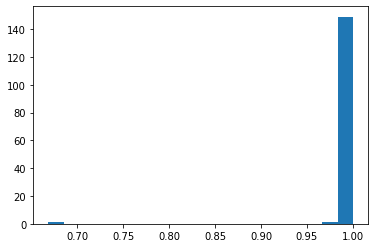

In [24]:
plt.hist(base_pcs[base_pcs.prob_inclusion_insol > 1/400].prob_inclusion_teff, 20);

In [ ]:
701.03 in pcs.KOI

In [ ]:
np.isclose(pcs.KOI, 701.03).any()

In [ ]:
prob_pcs[prob_pcs.KOI == 4636.01].koi_prad_err1

In [ ]:
prob_pcs[prob_pcs.KOI == 4636.01].gaia_iso_prad_errp

In [6]:
list(base_pcs)

['kepid_x',
 'kepoi_name',
 'koi_tce_plnt_num',
 'koi_pdisposition',
 'koi_score',
 'koi_period',
 'koi_max_mult_ev',
 'koi_prad',
 'koi_prad_err1',
 'koi_prad_err2',
 'koi_ror',
 'koi_ror_err1',
 'koi_ror_err2',
 'KIC',
 'KOI',
 'koi_disposition',
 'gaia_iso_prad',
 'gaia_iso_prad_errp',
 'gaia_iso_prad_errm',
 'gaia_iso_sma',
 'gaia_iso_sma_errp',
 'gaia_iso_sma_errm',
 'gaia_iso_insol',
 'gaia_iso_insol_errp',
 'gaia_iso_insol_errm',
 'ZAMSFlux',
 'Flag',
 'insolation',
 'TCE_ID',
 'radius',
 'radius_err1',
 'radius_err2',
 'teff',
 'teff_err1',
 'teff_err2',
 'corrected_prad',
 'corrected_prad_err1',
 'corrected_prad_err2',
 'rowid',
 'kepid_y',
 'fpp_koi_period',
 'fpp_prob',
 'fpEffectiveness',
 'obsFpRate',
 'reliability',
 'fpp_prob_use',
 'totalReliability',
 'Disp',
 'prob_inclusion_radius',
 'prob_inclusion_insol',
 'prob_inclusion_teff']

In [15]:
len(prob_pcs)

117

In [17]:
sprob_pcs = prob_pcs.sort_values("prob_inclusion", ascending=False)

In [22]:
sprob_pcs

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,fpEffectiveness,obsFpRate,reliability,fpp_prob_use,totalReliability,Disp,prob_inclusion_radius,prob_inclusion_insol,prob_inclusion_teff,prob_inclusion
1891,4138008,K04742.01,1,CANDIDATE,0.993,112.303136,12.923793,1.30,0.07,-0.05,...,0.995950,0.323238,0.998058,0.09000,0.908232,PC,1.000000,1.000000,1.000000,1.000000
2307,5802205,K08107.01,1,CANDIDATE,0.381,578.887610,7.586177,1.69,0.45,-0.67,...,0.993533,0.983084,0.621722,0.00250,0.620168,PC,1.000000,1.000000,1.000000,1.000000
2356,8311864,K07016.01,1,CANDIDATE,0.771,384.847556,7.602392,1.09,0.20,-0.10,...,0.991249,0.973007,0.681760,0.00860,0.675897,PC,1.000000,1.000000,1.000000,1.000000
1357,5184911,K02719.02,2,CANDIDATE,0.990,106.259760,10.022375,1.50,0.10,-0.16,...,0.995846,0.403468,0.997178,0.04000,0.957291,PC,1.000000,1.000000,1.000000,1.000000
2508,9002278,K00701.03,3,CANDIDATE,0.994,122.385868,35.940640,1.72,0.10,-0.07,...,0.995950,0.015811,0.999935,0.00280,0.997135,PC,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,3217264,K00401.02,2,CANDIDATE,1.000,160.019160,46.990246,4.28,0.50,-0.33,...,0.995950,0.005316,0.999978,0.05200,0.947979,PC,0.000848,0.678187,1.000000,0.000575
182,10166274,K01078.03,3,CANDIDATE,0.992,28.464648,22.192923,1.87,0.14,-0.22,...,0.995950,0.028613,0.999880,0.00012,0.999760,PC,0.999837,0.000488,0.967586,0.000472
483,9650808,K01970.02,2,CANDIDATE,0.899,125.602323,19.515469,2.89,0.81,-0.35,...,0.995950,0.176609,0.999128,0.00073,0.998398,PC,0.091889,0.004394,1.000000,0.000404
1893,9782748,K04856.01,1,CANDIDATE,0.924,147.388124,13.097614,3.03,1.00,-0.34,...,0.995950,0.449405,0.996681,0.00150,0.995186,PC,0.024800,0.011613,1.000000,0.000288


In [20]:
from astropy.io import ascii
paperTable = ascii.read("../../papers/paper3/proof/AAS27024R2_datafile8.txt")
paperTable

KOI,f_KOI,Radius,E_Radius,e_Radius,Period,Instel,E_Instel,e_Instel,Teff,E_Teff,e_Teff,Rel,IncProb
,,Rgeo,Rgeo,Rgeo,d,,,,K,K,K,,
str7,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64
4742.01,b,1.35,0.08,0.08,112.3,1.01,0.08,0.07,4602,84,76,0.91,1.0
8107.01,b,1.19,0.06,0.06,578.89,1.0,0.08,0.08,5832,102,103,0.62,1.0
7016.01,b,1.46,0.09,0.08,384.85,1.11,0.08,0.08,5900,102,100,0.68,1.0
2719.02,b,1.25,0.15,0.08,106.26,1.25,0.1,0.09,4601,81,76,0.96,1.0
701.03,b,1.8,0.07,0.04,122.39,1.44,0.11,0.1,4966,82,82,1.0,1.0
4036.01,b,1.71,0.12,0.08,168.81,0.77,0.05,0.05,4697,76,68,1.0,1.0
2194.03,b,1.8,0.1,0.14,445.22,1.36,0.13,0.12,5965,122,116,0.68,1.0
4087.01,b,1.8,0.1,0.08,101.11,0.82,0.07,0.07,4171,56,49,1.0,1.0


In [39]:
paperTable[0][2]

1.35

In [56]:
i = 0
for ii, p in prob_pcs.sort_values("prob_inclusion", ascending=False).iterrows():
    if p.KOI != float(paperTable[i][0]):
        print("KOI error " + str(p.KOI) + " " + paperTable[i][0])
    if round(p.gaia_iso_prad,2) != paperTable[i][2]:
        print("gaia_iso_prad error" + str(p.KOI) + " " + str(round(p.gaia_iso_prad,2)) + " " + str(paperTable[i][2]))
    if round(p.gaia_iso_prad_errp,2) != paperTable[i][3]:
        print("gaia_iso_prad_errp error " + str(p.KOI) + " " + str(round(p.gaia_iso_prad_errp,2)) + " " + str(paperTable[i][3]))
    if round(p.gaia_iso_prad_errm,2) != paperTable[i][4]:
        print("gaia_iso_prad_errm error " + str(p.KOI) + " " + str(round(p.gaia_iso_prad_errm,2)) + " " + str(paperTable[i][4]))
    if round(p.koi_period,2) != paperTable[i][5]:
        print("koi_period error " + str(p.KOI) + " " + str(round(p.koi_period,2)) + " " + str(paperTable[i][5]))
    if round(p.gaia_iso_insol,2) != paperTable[i][6]:
        print("gaia_iso_insol error " + str(p.KOI) + " " + str(round(p.gaia_iso_insol,2)) + " " + str(paperTable[i][6]))
    if round(p.gaia_iso_insol_errp,2) != paperTable[i][7]:
        print("gaia_iso_insol_errp error " + str(p.KOI) + " " + str(round(p.gaia_iso_insol_errp,2)) + " " + str(paperTable[i][7]))
    if round(p.gaia_iso_insol_errm,2) != paperTable[i][8]:
        print("gaia_iso_insol_errm error " + str(p.KOI) + " " + str(round(p.gaia_iso_insol_errm,2)) + " " + str(paperTable[i][8]))
    if round(p.teff,0) != paperTable[i][9]:
        print("teff error " + str(p.KOI) + " " + str(round(p.teff,0)) + " " + str(paperTable[i][9]))
    if round(p.teff_err1,0) != paperTable[i][10]:
        print("teff_err1 error " + str(p.KOI) + " " + str(round(p.teff_err1,0)) + " " + str(paperTable[i][10]))
    if round(p.teff_err2,0) != paperTable[i][11]:
        print("teff_err2 error " + str(p.KOI) + " " + str(round(p.teff_err2,0)) + " " + str(paperTable[i][11]))
    if round(p.totalReliability,2) != paperTable[i][12]:
        print("totalReliability error " + str(p.KOI) + " " + str(round(p.totalReliability,2)) + " " + str(paperTable[i][12]))
    if round(p.prob_inclusion,5) != paperTable[i][13]:
        print("prob_inclusion error " + str(p.KOI) + " " + str(round(p.prob_inclusion,5)) + " " + str(paperTable[i][13]))
    i += 1